# **Code de reproduction de l'article :** How transferable are features in deep neural networks?

In [7]:
%load_ext autoreload
%autoreload 2
import os
import json
from tqdm import tqdm
import torch 
import torch.nn as nn
import models
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import Adam
print(f"device avaible : {'cuda' if torch.cuda.is_available() else 'cpu'}")
import matplotlib.pyplot as plt
from torch.nn import Conv2d, Linear

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device avaible : cuda


# **Dataset**

Création de deux datasets distincts : 
- A contient les chiffres de 0 à 4
- B contient les chiffres de 5 à 9 

In [2]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0 
X_test = torch.tensor(X_test.values, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# création des datasets A (0-4) et B (5-9)
def create_subset(X, y, class_range):
    indices = [i for i, label in enumerate(y) if label in class_range]
    return Subset(torch.utils.data.TensorDataset(X, y), indices)

train_set_A = create_subset(X_train, y_train, range(0, 5))
train_set_B = create_subset(X_train, y_train, range(5, 10))

test_set_A = create_subset(X_test, y_test, range(0, 5))
test_set_B = create_subset(X_test, y_test, range(5, 10))


train_loader_A = DataLoader(train_set_A, batch_size=64, shuffle=True)
train_loader_B = DataLoader(train_set_B, batch_size=64, shuffle=True)

test_loader_A = DataLoader(test_set_A, batch_size=64, shuffle=False)
test_loader_B = DataLoader(test_set_B, batch_size=64, shuffle=False)

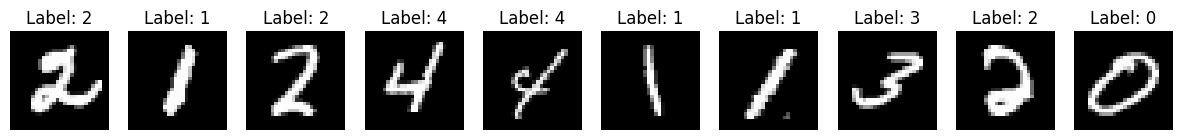

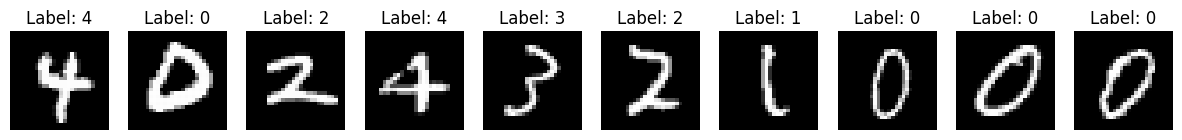

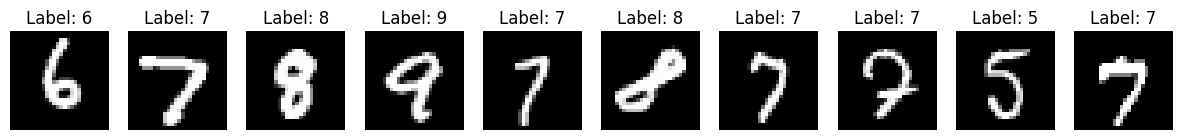

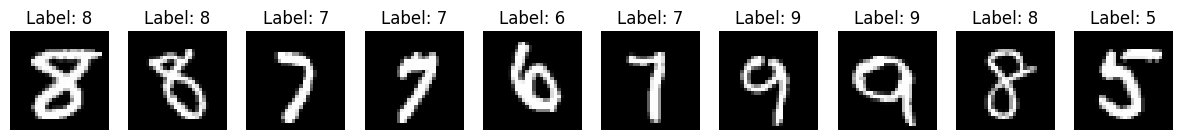

In [4]:


def visualize_dataloader_samples(dataloader, num_samples=10):
    images, labels = next(iter(dataloader))
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label.item()}")
    plt.show()


visualize_dataloader_samples(train_loader_A)
visualize_dataloader_samples(test_loader_A)
visualize_dataloader_samples(train_loader_B)
visualize_dataloader_samples(test_loader_B)


# **Entraînement des modèles de bases**

In [ ]:
loss_fn = nn.CrossEntropyLoss()
path = "./resultats/"

resA  = []
resB = []
print("Entrainement du modèle A")
print()
for _ in range(10): 
    modelA = models.CNN()
    optimizerA = Adam(modelA.parameters())
    modelA.train_model(train_loader_A,test_loader_A, loss_fn, n_epochs=2, optimizer=optimizerA)
    resA.append(modelA.test(test_loader_A))
torch.save(modelA, "./models/baseA.torch")

print()
print("Entrainement du modèle B")
print()
for _ in range(10): 
    modelB = models.CNN()
    optimizerB= Adam(modelB.parameters())
    modelB.train_model(train_loader_B,test_loader_B, loss_fn, n_epochs=2, optimizer=optimizerB)
    resB.append(modelB.test(test_loader_B))
torch.save(modelB, "./models/baseB.torch")

with open(os.path.join(path, "base.json"), 'a') as file:
        json.dump({"model A" : resA}, file)
        json.dump({"model B" : resB}, file)

# **Réentrainement des modèles**

Nous réalisons l'expérience décrite dans le papier. Nous prenons le modèle B comme référence. Nous allons faire une boucle pour itérer sur le nombre de couche du réseau. Commençons pas le cas ou les paramètres des couches copiées sont gelés. Les paramètres du classifieur sont toujours réappris

## modèles BNB

In [15]:


path = "./resultats/"
basemodel = torch.load("./models/baseB.torch")
loss_fn = nn.CrossEntropyLoss()

def get_trainable_layer_indices(model):
    return [i for i, layer in enumerate(model.model) if isinstance(layer, (Conv2d, Linear))]


trainable_indices = get_trainable_layer_indices(basemodel)
final = {}
for j in tqdm(range(1, len(trainable_indices) ), desc="Etape "):
    l = []
    for _ in range(7):
        newmodel = models.CNN()
        for i in trainable_indices[:j]:
            newmodel.model[i] = basemodel.model[i]
            for param in newmodel.model[i].parameters():
                param.requires_grad = False

        optimizer = Adam(filter(lambda p: p.requires_grad, newmodel.parameters()))
        newmodel.train_model(train_loader_B, test_loader_B, loss_fn, n_epochs=2, optimizer=optimizer)
        l.append(newmodel.test(test_loader_B))

    res = {
        "model base": "B",
        "couche copiees": j,
        "couche reentrainees": 8 - j,
        "resultats": l
    }
    final[j] = res
with open(os.path.join(path, "BNB.json"), 'w') as file:
    json.dump(final, file, indent=4)

/tmp/ipykernel_4732/2009541652.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  basemodel = torch.load("./models/baseB.torch")
Etape :   0%|          | 0/7 [00:00<?, ?it/

Epoch 1, Loss: 0.2148
Test set: Avg. loss: 0.0724, Accuracy: 6798/6949 (97.83%)
Epoch 2, Loss: 0.0409
Test set: Avg. loss: 0.0342, Accuracy: 6879/6949 (98.99%)
Test set: Avg. loss: 0.0342, Accuracy: 6879/6949 (98.99%)
Epoch 1, Loss: 0.2052
Test set: Avg. loss: 0.0468, Accuracy: 6844/6949 (98.49%)
Epoch 2, Loss: 0.0430
Test set: Avg. loss: 0.0336, Accuracy: 6881/6949 (99.02%)
Test set: Avg. loss: 0.0336, Accuracy: 6881/6949 (99.02%)
Epoch 1, Loss: 0.2073
Test set: Avg. loss: 0.0560, Accuracy: 6842/6949 (98.46%)
Epoch 2, Loss: 0.0406
Test set: Avg. loss: 0.0326, Accuracy: 6876/6949 (98.95%)
Test set: Avg. loss: 0.0326, Accuracy: 6876/6949 (98.95%)
Epoch 1, Loss: 0.2017
Test set: Avg. loss: 0.0386, Accuracy: 6857/6949 (98.68%)
Epoch 2, Loss: 0.0375
Test set: Avg. loss: 0.0309, Accuracy: 6879/6949 (98.99%)
Test set: Avg. loss: 0.0309, Accuracy: 6879/6949 (98.99%)
Epoch 1, Loss: 0.2343
Test set: Avg. loss: 0.0602, Accuracy: 6819/6949 (98.13%)
Epoch 2, Loss: 0.0398
Test set: Avg. loss: 0.032

Etape :  14%|█▍        | 1/7 [01:29<08:56, 89.38s/it]

Test set: Avg. loss: 0.0370, Accuracy: 6871/6949 (98.88%)
Epoch 1, Loss: 0.1643
Test set: Avg. loss: 0.0296, Accuracy: 6881/6949 (99.02%)
Epoch 2, Loss: 0.0366
Test set: Avg. loss: 0.0311, Accuracy: 6878/6949 (98.98%)
Test set: Avg. loss: 0.0311, Accuracy: 6878/6949 (98.98%)
Epoch 1, Loss: 0.1813
Test set: Avg. loss: 0.0566, Accuracy: 6829/6949 (98.27%)
Epoch 2, Loss: 0.0347
Test set: Avg. loss: 0.0354, Accuracy: 6877/6949 (98.96%)
Test set: Avg. loss: 0.0354, Accuracy: 6877/6949 (98.96%)
Epoch 1, Loss: 0.1517
Test set: Avg. loss: 0.0467, Accuracy: 6858/6949 (98.69%)
Epoch 2, Loss: 0.0394
Test set: Avg. loss: 0.0313, Accuracy: 6883/6949 (99.05%)
Test set: Avg. loss: 0.0313, Accuracy: 6883/6949 (99.05%)
Epoch 1, Loss: 0.1700
Test set: Avg. loss: 0.0411, Accuracy: 6865/6949 (98.79%)
Epoch 2, Loss: 0.0405
Test set: Avg. loss: 0.0451, Accuracy: 6863/6949 (98.76%)
Test set: Avg. loss: 0.0451, Accuracy: 6863/6949 (98.76%)
Epoch 1, Loss: 0.1626
Test set: Avg. loss: 0.0597, Accuracy: 6826/6949

Etape :  29%|██▊       | 2/7 [02:57<07:22, 88.54s/it]

Test set: Avg. loss: 0.0408, Accuracy: 6853/6949 (98.62%)
Epoch 1, Loss: 0.1373
Test set: Avg. loss: 0.0334, Accuracy: 6875/6949 (98.94%)
Epoch 2, Loss: 0.0386
Test set: Avg. loss: 0.0264, Accuracy: 6890/6949 (99.15%)
Test set: Avg. loss: 0.0264, Accuracy: 6890/6949 (99.15%)
Epoch 1, Loss: 0.1398
Test set: Avg. loss: 0.0506, Accuracy: 6830/6949 (98.29%)
Epoch 2, Loss: 0.0362
Test set: Avg. loss: 0.0394, Accuracy: 6858/6949 (98.69%)
Test set: Avg. loss: 0.0394, Accuracy: 6858/6949 (98.69%)
Epoch 1, Loss: 0.1535
Test set: Avg. loss: 0.0462, Accuracy: 6846/6949 (98.52%)
Epoch 2, Loss: 0.0429
Test set: Avg. loss: 0.0341, Accuracy: 6868/6949 (98.83%)
Test set: Avg. loss: 0.0341, Accuracy: 6868/6949 (98.83%)
Epoch 1, Loss: 0.1610
Test set: Avg. loss: 0.0484, Accuracy: 6844/6949 (98.49%)
Epoch 2, Loss: 0.0382
Test set: Avg. loss: 0.0378, Accuracy: 6863/6949 (98.76%)
Test set: Avg. loss: 0.0378, Accuracy: 6863/6949 (98.76%)
Epoch 1, Loss: 0.1499
Test set: Avg. loss: 0.0418, Accuracy: 6859/6949

Etape :  43%|████▎     | 3/7 [04:23<05:50, 87.57s/it]

Test set: Avg. loss: 0.0537, Accuracy: 6835/6949 (98.36%)
Epoch 1, Loss: 0.1069
Test set: Avg. loss: 0.0352, Accuracy: 6869/6949 (98.85%)
Epoch 2, Loss: 0.0313
Test set: Avg. loss: 0.0275, Accuracy: 6883/6949 (99.05%)
Test set: Avg. loss: 0.0275, Accuracy: 6883/6949 (99.05%)
Epoch 1, Loss: 0.1051
Test set: Avg. loss: 0.0349, Accuracy: 6882/6949 (99.04%)
Epoch 2, Loss: 0.0358
Test set: Avg. loss: 0.0395, Accuracy: 6872/6949 (98.89%)
Test set: Avg. loss: 0.0395, Accuracy: 6872/6949 (98.89%)
Epoch 1, Loss: 0.1108
Test set: Avg. loss: 0.0621, Accuracy: 6811/6949 (98.01%)
Epoch 2, Loss: 0.0361
Test set: Avg. loss: 0.0304, Accuracy: 6885/6949 (99.08%)
Test set: Avg. loss: 0.0304, Accuracy: 6885/6949 (99.08%)
Epoch 1, Loss: 0.1075
Test set: Avg. loss: 0.0327, Accuracy: 6877/6949 (98.96%)
Epoch 2, Loss: 0.0358
Test set: Avg. loss: 0.0302, Accuracy: 6891/6949 (99.17%)
Test set: Avg. loss: 0.0302, Accuracy: 6891/6949 (99.17%)
Epoch 1, Loss: 0.1048
Test set: Avg. loss: 0.0369, Accuracy: 6873/6949

Etape :  57%|█████▋    | 4/7 [05:48<04:19, 86.60s/it]

Test set: Avg. loss: 0.0325, Accuracy: 6879/6949 (98.99%)
Epoch 1, Loss: 0.0942
Test set: Avg. loss: 0.0433, Accuracy: 6857/6949 (98.68%)
Epoch 2, Loss: 0.0351
Test set: Avg. loss: 0.0485, Accuracy: 6863/6949 (98.76%)
Test set: Avg. loss: 0.0485, Accuracy: 6863/6949 (98.76%)
Epoch 1, Loss: 0.0878
Test set: Avg. loss: 0.0460, Accuracy: 6853/6949 (98.62%)
Epoch 2, Loss: 0.0365
Test set: Avg. loss: 0.0454, Accuracy: 6859/6949 (98.70%)
Test set: Avg. loss: 0.0454, Accuracy: 6859/6949 (98.70%)
Epoch 1, Loss: 0.0901
Test set: Avg. loss: 0.0724, Accuracy: 6786/6949 (97.65%)
Epoch 2, Loss: 0.0358
Test set: Avg. loss: 0.0573, Accuracy: 6845/6949 (98.50%)
Test set: Avg. loss: 0.0573, Accuracy: 6845/6949 (98.50%)
Epoch 1, Loss: 0.0901
Test set: Avg. loss: 0.0475, Accuracy: 6840/6949 (98.43%)
Epoch 2, Loss: 0.0375
Test set: Avg. loss: 0.0301, Accuracy: 6884/6949 (99.06%)
Test set: Avg. loss: 0.0301, Accuracy: 6884/6949 (99.06%)
Epoch 1, Loss: 0.0890
Test set: Avg. loss: 0.0434, Accuracy: 6850/6949

Etape :  71%|███████▏  | 5/7 [07:07<02:47, 83.83s/it]

Test set: Avg. loss: 0.0382, Accuracy: 6865/6949 (98.79%)
Epoch 1, Loss: 0.0325
Test set: Avg. loss: 0.0400, Accuracy: 6865/6949 (98.79%)
Epoch 2, Loss: 0.0161
Test set: Avg. loss: 0.0344, Accuracy: 6880/6949 (99.01%)
Test set: Avg. loss: 0.0344, Accuracy: 6880/6949 (99.01%)
Epoch 1, Loss: 0.0327
Test set: Avg. loss: 0.0382, Accuracy: 6872/6949 (98.89%)
Epoch 2, Loss: 0.0173
Test set: Avg. loss: 0.0391, Accuracy: 6882/6949 (99.04%)
Test set: Avg. loss: 0.0391, Accuracy: 6882/6949 (99.04%)
Epoch 1, Loss: 0.0329
Test set: Avg. loss: 0.0342, Accuracy: 6875/6949 (98.94%)
Epoch 2, Loss: 0.0159
Test set: Avg. loss: 0.0372, Accuracy: 6877/6949 (98.96%)
Test set: Avg. loss: 0.0372, Accuracy: 6877/6949 (98.96%)
Epoch 1, Loss: 0.0322
Test set: Avg. loss: 0.0392, Accuracy: 6868/6949 (98.83%)
Epoch 2, Loss: 0.0164
Test set: Avg. loss: 0.0747, Accuracy: 6832/6949 (98.32%)
Test set: Avg. loss: 0.0747, Accuracy: 6832/6949 (98.32%)
Epoch 1, Loss: 0.0310
Test set: Avg. loss: 0.0416, Accuracy: 6873/6949

Etape :  86%|████████▌ | 6/7 [07:30<01:03, 63.07s/it]

Test set: Avg. loss: 0.0412, Accuracy: 6868/6949 (98.83%)
Epoch 1, Loss: 0.0616
Test set: Avg. loss: 0.0333, Accuracy: 6877/6949 (98.96%)
Epoch 2, Loss: 0.0165
Test set: Avg. loss: 0.0337, Accuracy: 6882/6949 (99.04%)
Test set: Avg. loss: 0.0337, Accuracy: 6882/6949 (99.04%)
Epoch 1, Loss: 0.0492
Test set: Avg. loss: 0.0337, Accuracy: 6873/6949 (98.91%)
Epoch 2, Loss: 0.0160
Test set: Avg. loss: 0.0352, Accuracy: 6870/6949 (98.86%)
Test set: Avg. loss: 0.0352, Accuracy: 6870/6949 (98.86%)
Epoch 1, Loss: 0.0491
Test set: Avg. loss: 0.0334, Accuracy: 6872/6949 (98.89%)
Epoch 2, Loss: 0.0165
Test set: Avg. loss: 0.0349, Accuracy: 6870/6949 (98.86%)
Test set: Avg. loss: 0.0349, Accuracy: 6870/6949 (98.86%)
Epoch 1, Loss: 0.0538
Test set: Avg. loss: 0.0341, Accuracy: 6867/6949 (98.82%)
Epoch 2, Loss: 0.0167
Test set: Avg. loss: 0.0339, Accuracy: 6881/6949 (99.02%)
Test set: Avg. loss: 0.0339, Accuracy: 6881/6949 (99.02%)
Epoch 1, Loss: 0.0651
Test set: Avg. loss: 0.0325, Accuracy: 6872/6949

Etape : 100%|██████████| 7/7 [07:50<00:00, 67.18s/it]

Test set: Avg. loss: 0.0348, Accuracy: 6873/6949 (98.91%)


## Modèles AnB

In [16]:
basemodel = torch.load("./models/baseA.torch")
loss_fn = nn.CrossEntropyLoss()


trainable_indices = get_trainable_layer_indices(basemodel)
final = {}
for j in tqdm(range(1, len(trainable_indices) ), desc="Etape "):
    l = []
    for _ in range(7):
        newmodel = models.CNN()
        for i in trainable_indices[:j]:
            newmodel.model[i] = basemodel.model[i]
            for param in newmodel.model[i].parameters():
                param.requires_grad = False

        optimizer = Adam(filter(lambda p: p.requires_grad, newmodel.parameters()))
        newmodel.train_model(train_loader_B, test_loader_B, loss_fn, n_epochs=2, optimizer=optimizer)
        l.append(newmodel.test(test_loader_B))

    res = {
        "model base": "B",
        "couche copiees": j,
        "couche reentrainees": 8 - j,
        "resultats": l
    }
    final[j] = res
with open(os.path.join(path, "ANB.json"), 'w') as file:
    json.dump(final, file, indent=4)

/tmp/ipykernel_4732/2938046501.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  basemodel = torch.load("./models/baseA.torch")
Etape :   0%|          | 0/7 [00:00<?, ?it/

Epoch 1, Loss: 0.2431
Test set: Avg. loss: 0.0724, Accuracy: 6791/6949 (97.73%)
Epoch 2, Loss: 0.0374
Test set: Avg. loss: 0.0261, Accuracy: 6894/6949 (99.21%)
Test set: Avg. loss: 0.0261, Accuracy: 6894/6949 (99.21%)
Epoch 1, Loss: 0.2439
Test set: Avg. loss: 0.0466, Accuracy: 6849/6949 (98.56%)
Epoch 2, Loss: 0.0425
Test set: Avg. loss: 0.0379, Accuracy: 6874/6949 (98.92%)
Test set: Avg. loss: 0.0379, Accuracy: 6874/6949 (98.92%)
Epoch 1, Loss: 0.2165
Test set: Avg. loss: 0.0490, Accuracy: 6836/6949 (98.37%)
Epoch 2, Loss: 0.0389
Test set: Avg. loss: 0.0446, Accuracy: 6846/6949 (98.52%)
Test set: Avg. loss: 0.0446, Accuracy: 6846/6949 (98.52%)
Epoch 1, Loss: 0.2120
Test set: Avg. loss: 0.0482, Accuracy: 6841/6949 (98.45%)
Epoch 2, Loss: 0.0420
Test set: Avg. loss: 0.0400, Accuracy: 6866/6949 (98.81%)
Test set: Avg. loss: 0.0400, Accuracy: 6866/6949 (98.81%)
Epoch 1, Loss: 0.2616
Test set: Avg. loss: 0.0447, Accuracy: 6847/6949 (98.53%)
Epoch 2, Loss: 0.0380
Test set: Avg. loss: 0.030

Etape :  14%|█▍        | 1/7 [01:29<08:56, 89.47s/it]

Test set: Avg. loss: 0.0328, Accuracy: 6871/6949 (98.88%)
Epoch 1, Loss: 0.1516
Test set: Avg. loss: 0.0454, Accuracy: 6856/6949 (98.66%)
Epoch 2, Loss: 0.0373
Test set: Avg. loss: 0.0339, Accuracy: 6879/6949 (98.99%)
Test set: Avg. loss: 0.0339, Accuracy: 6879/6949 (98.99%)
Epoch 1, Loss: 0.1777
Test set: Avg. loss: 0.0541, Accuracy: 6833/6949 (98.33%)
Epoch 2, Loss: 0.0381
Test set: Avg. loss: 0.0382, Accuracy: 6865/6949 (98.79%)
Test set: Avg. loss: 0.0382, Accuracy: 6865/6949 (98.79%)
Epoch 1, Loss: 0.1785
Test set: Avg. loss: 0.0441, Accuracy: 6843/6949 (98.47%)
Epoch 2, Loss: 0.0409
Test set: Avg. loss: 0.0370, Accuracy: 6864/6949 (98.78%)
Test set: Avg. loss: 0.0370, Accuracy: 6864/6949 (98.78%)
Epoch 1, Loss: 0.1821
Test set: Avg. loss: 0.0473, Accuracy: 6850/6949 (98.58%)
Epoch 2, Loss: 0.0389
Test set: Avg. loss: 0.0332, Accuracy: 6879/6949 (98.99%)
Test set: Avg. loss: 0.0332, Accuracy: 6879/6949 (98.99%)
Epoch 1, Loss: 0.1666
Test set: Avg. loss: 0.0556, Accuracy: 6831/6949

Etape :  29%|██▊       | 2/7 [02:57<07:24, 88.90s/it]

Test set: Avg. loss: 0.0326, Accuracy: 6884/6949 (99.06%)
Epoch 1, Loss: 0.1578
Test set: Avg. loss: 0.0486, Accuracy: 6848/6949 (98.55%)
Epoch 2, Loss: 0.0405
Test set: Avg. loss: 0.0388, Accuracy: 6864/6949 (98.78%)
Test set: Avg. loss: 0.0388, Accuracy: 6864/6949 (98.78%)
Epoch 1, Loss: 0.1514
Test set: Avg. loss: 0.0455, Accuracy: 6839/6949 (98.42%)
Epoch 2, Loss: 0.0394
Test set: Avg. loss: 0.0359, Accuracy: 6870/6949 (98.86%)
Test set: Avg. loss: 0.0359, Accuracy: 6870/6949 (98.86%)
Epoch 1, Loss: 0.1451
Test set: Avg. loss: 0.0411, Accuracy: 6856/6949 (98.66%)
Epoch 2, Loss: 0.0368
Test set: Avg. loss: 0.0322, Accuracy: 6879/6949 (98.99%)
Test set: Avg. loss: 0.0322, Accuracy: 6879/6949 (98.99%)
Epoch 1, Loss: 0.1675
Test set: Avg. loss: 0.0387, Accuracy: 6863/6949 (98.76%)
Epoch 2, Loss: 0.0376
Test set: Avg. loss: 0.0296, Accuracy: 6897/6949 (99.25%)
Test set: Avg. loss: 0.0296, Accuracy: 6897/6949 (99.25%)
Epoch 1, Loss: 0.1676
Test set: Avg. loss: 0.0504, Accuracy: 6840/6949

Etape :  43%|████▎     | 3/7 [04:24<05:52, 88.01s/it]

Test set: Avg. loss: 0.0491, Accuracy: 6845/6949 (98.50%)
Epoch 1, Loss: 0.1343
Test set: Avg. loss: 0.0439, Accuracy: 6852/6949 (98.60%)
Epoch 2, Loss: 0.0352
Test set: Avg. loss: 0.0298, Accuracy: 6880/6949 (99.01%)
Test set: Avg. loss: 0.0298, Accuracy: 6880/6949 (99.01%)
Epoch 1, Loss: 0.1214
Test set: Avg. loss: 0.0443, Accuracy: 6862/6949 (98.75%)
Epoch 2, Loss: 0.0343
Test set: Avg. loss: 0.0343, Accuracy: 6879/6949 (98.99%)
Test set: Avg. loss: 0.0343, Accuracy: 6879/6949 (98.99%)
Epoch 1, Loss: 0.1203
Test set: Avg. loss: 0.0443, Accuracy: 6855/6949 (98.65%)
Epoch 2, Loss: 0.0365
Test set: Avg. loss: 0.0360, Accuracy: 6869/6949 (98.85%)
Test set: Avg. loss: 0.0360, Accuracy: 6869/6949 (98.85%)
Epoch 1, Loss: 0.1142
Test set: Avg. loss: 0.0621, Accuracy: 6818/6949 (98.11%)
Epoch 2, Loss: 0.0370
Test set: Avg. loss: 0.0362, Accuracy: 6866/6949 (98.81%)
Test set: Avg. loss: 0.0362, Accuracy: 6866/6949 (98.81%)
Epoch 1, Loss: 0.1206
Test set: Avg. loss: 0.0404, Accuracy: 6852/6949

Etape :  57%|█████▋    | 4/7 [05:50<04:21, 87.05s/it]

Test set: Avg. loss: 0.0387, Accuracy: 6873/6949 (98.91%)
Epoch 1, Loss: 0.1043
Test set: Avg. loss: 0.0578, Accuracy: 6828/6949 (98.26%)
Epoch 2, Loss: 0.0411
Test set: Avg. loss: 0.0483, Accuracy: 6836/6949 (98.37%)
Test set: Avg. loss: 0.0483, Accuracy: 6836/6949 (98.37%)
Epoch 1, Loss: 0.1047
Test set: Avg. loss: 0.0417, Accuracy: 6855/6949 (98.65%)
Epoch 2, Loss: 0.0403
Test set: Avg. loss: 0.0419, Accuracy: 6857/6949 (98.68%)
Test set: Avg. loss: 0.0419, Accuracy: 6857/6949 (98.68%)
Epoch 1, Loss: 0.0996
Test set: Avg. loss: 0.0537, Accuracy: 6832/6949 (98.32%)
Epoch 2, Loss: 0.0416
Test set: Avg. loss: 0.0449, Accuracy: 6856/6949 (98.66%)
Test set: Avg. loss: 0.0449, Accuracy: 6856/6949 (98.66%)
Epoch 1, Loss: 0.1010
Test set: Avg. loss: 0.0849, Accuracy: 6760/6949 (97.28%)
Epoch 2, Loss: 0.0378
Test set: Avg. loss: 0.0889, Accuracy: 6796/6949 (97.80%)
Test set: Avg. loss: 0.0889, Accuracy: 6796/6949 (97.80%)
Epoch 1, Loss: 0.1044
Test set: Avg. loss: 0.0501, Accuracy: 6837/6949

Etape :  71%|███████▏  | 5/7 [07:09<02:48, 84.18s/it]

Test set: Avg. loss: 0.0395, Accuracy: 6857/6949 (98.68%)
Epoch 1, Loss: 0.1561
Test set: Avg. loss: 0.0824, Accuracy: 6778/6949 (97.54%)
Epoch 2, Loss: 0.0757
Test set: Avg. loss: 0.0650, Accuracy: 6811/6949 (98.01%)
Test set: Avg. loss: 0.0650, Accuracy: 6811/6949 (98.01%)
Epoch 1, Loss: 0.1509
Test set: Avg. loss: 0.0843, Accuracy: 6746/6949 (97.08%)
Epoch 2, Loss: 0.0739
Test set: Avg. loss: 0.0804, Accuracy: 6758/6949 (97.25%)
Test set: Avg. loss: 0.0804, Accuracy: 6758/6949 (97.25%)
Epoch 1, Loss: 0.1501
Test set: Avg. loss: 0.1016, Accuracy: 6735/6949 (96.92%)
Epoch 2, Loss: 0.0729
Test set: Avg. loss: 0.0813, Accuracy: 6766/6949 (97.37%)
Test set: Avg. loss: 0.0813, Accuracy: 6766/6949 (97.37%)
Epoch 1, Loss: 0.1535
Test set: Avg. loss: 0.0964, Accuracy: 6745/6949 (97.06%)
Epoch 2, Loss: 0.0760
Test set: Avg. loss: 0.0771, Accuracy: 6776/6949 (97.51%)
Test set: Avg. loss: 0.0771, Accuracy: 6776/6949 (97.51%)
Epoch 1, Loss: 0.1536
Test set: Avg. loss: 0.1322, Accuracy: 6635/6949

Etape :  86%|████████▌ | 6/7 [07:33<01:03, 63.57s/it]

Test set: Avg. loss: 0.0833, Accuracy: 6770/6949 (97.42%)
Epoch 1, Loss: 0.6891
Test set: Avg. loss: 0.5355, Accuracy: 5760/6949 (82.89%)
Epoch 2, Loss: 0.5099
Test set: Avg. loss: 0.4548, Accuracy: 5925/6949 (85.26%)
Test set: Avg. loss: 0.4548, Accuracy: 5925/6949 (85.26%)
Epoch 1, Loss: 0.6779
Test set: Avg. loss: 0.5299, Accuracy: 5702/6949 (82.05%)
Epoch 2, Loss: 0.5078
Test set: Avg. loss: 0.4563, Accuracy: 5939/6949 (85.47%)
Test set: Avg. loss: 0.4563, Accuracy: 5939/6949 (85.47%)
Epoch 1, Loss: 0.6722
Test set: Avg. loss: 0.5252, Accuracy: 5693/6949 (81.93%)
Epoch 2, Loss: 0.5021
Test set: Avg. loss: 0.4476, Accuracy: 5934/6949 (85.39%)
Test set: Avg. loss: 0.4476, Accuracy: 5934/6949 (85.39%)
Epoch 1, Loss: 0.7133
Test set: Avg. loss: 0.5520, Accuracy: 5783/6949 (83.22%)
Epoch 2, Loss: 0.5143
Test set: Avg. loss: 0.4575, Accuracy: 5919/6949 (85.18%)
Test set: Avg. loss: 0.4575, Accuracy: 5919/6949 (85.18%)
Epoch 1, Loss: 0.6929
Test set: Avg. loss: 0.5411, Accuracy: 5716/6949

Etape : 100%|██████████| 7/7 [07:53<00:00, 67.67s/it]

Test set: Avg. loss: 0.4583, Accuracy: 5940/6949 (85.48%)


Cette fois-ci on copie des paramètres mais on ne les gèles pas.

## Modèles BnB+

In [13]:
basemodel = torch.load("./models/baseB.torch")
loss_fn = nn.CrossEntropyLoss()

trainable_indices = get_trainable_layer_indices(basemodel)
final = {}
for j in tqdm(range(1, len(trainable_indices) ), desc="Etape "):
    l = []
    for _ in range(7):
        newmodel = models.CNN()
        for i in trainable_indices[:j]:
            newmodel.model[i] = basemodel.model[i]
            for param in newmodel.model[i].parameters():
                param.requires_grad = True

        optimizer = Adam(filter(lambda p: p.requires_grad, newmodel.parameters()))
        newmodel.train_model(train_loader_B, test_loader_B, loss_fn, n_epochs=2, optimizer=optimizer)
        l.append(newmodel.test(test_loader_B))

    res = {
        "model base": "B",
        "couche copiees": j,
        "couche reentrainees": 8 - j,
        "resultats": l
    }
    final[j] = res
with open(os.path.join(path, "BNB+.json"), 'w') as file:
    json.dump(final, file, indent=4)

/tmp/ipykernel_4732/3156965429.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  basemodel = torch.load("./models/baseB.torch")
Etape :   0%|          | 0/7 [00:00<?, ?it/

Epoch 1, Loss: 0.2214
Test set: Avg. loss: 0.0455, Accuracy: 6855/6949 (98.65%)
Epoch 2, Loss: 0.0383
Test set: Avg. loss: 0.0401, Accuracy: 6861/6949 (98.73%)
Test set: Avg. loss: 0.0401, Accuracy: 6861/6949 (98.73%)
Epoch 1, Loss: 0.1969
Test set: Avg. loss: 0.0393, Accuracy: 6873/6949 (98.91%)
Epoch 2, Loss: 0.0352
Test set: Avg. loss: 0.0290, Accuracy: 6885/6949 (99.08%)
Test set: Avg. loss: 0.0290, Accuracy: 6885/6949 (99.08%)
Epoch 1, Loss: 0.2034
Test set: Avg. loss: 0.0534, Accuracy: 6833/6949 (98.33%)
Epoch 2, Loss: 0.0384
Test set: Avg. loss: 0.0473, Accuracy: 6850/6949 (98.58%)
Test set: Avg. loss: 0.0473, Accuracy: 6850/6949 (98.58%)
Epoch 1, Loss: 0.1893
Test set: Avg. loss: 0.0393, Accuracy: 6870/6949 (98.86%)
Epoch 2, Loss: 0.0390
Test set: Avg. loss: 0.0329, Accuracy: 6878/6949 (98.98%)
Test set: Avg. loss: 0.0329, Accuracy: 6878/6949 (98.98%)
Epoch 1, Loss: 0.1896
Test set: Avg. loss: 0.0444, Accuracy: 6849/6949 (98.56%)
Epoch 2, Loss: 0.0388
Test set: Avg. loss: 0.039

Etape :  14%|█▍        | 1/7 [01:31<09:06, 91.17s/it]

Test set: Avg. loss: 0.0441, Accuracy: 6856/6949 (98.66%)
Epoch 1, Loss: 0.1752
Test set: Avg. loss: 0.0368, Accuracy: 6873/6949 (98.91%)
Epoch 2, Loss: 0.0363
Test set: Avg. loss: 0.0286, Accuracy: 6890/6949 (99.15%)
Test set: Avg. loss: 0.0286, Accuracy: 6890/6949 (99.15%)
Epoch 1, Loss: 0.1633
Test set: Avg. loss: 0.0527, Accuracy: 6841/6949 (98.45%)
Epoch 2, Loss: 0.0359
Test set: Avg. loss: 0.0300, Accuracy: 6885/6949 (99.08%)
Test set: Avg. loss: 0.0300, Accuracy: 6885/6949 (99.08%)
Epoch 1, Loss: 0.1311
Test set: Avg. loss: 0.0424, Accuracy: 6859/6949 (98.70%)
Epoch 2, Loss: 0.0339
Test set: Avg. loss: 0.0355, Accuracy: 6872/6949 (98.89%)
Test set: Avg. loss: 0.0355, Accuracy: 6872/6949 (98.89%)
Epoch 1, Loss: 0.1474
Test set: Avg. loss: 0.0344, Accuracy: 6874/6949 (98.92%)
Epoch 2, Loss: 0.0320
Test set: Avg. loss: 0.0263, Accuracy: 6885/6949 (99.08%)
Test set: Avg. loss: 0.0263, Accuracy: 6885/6949 (99.08%)
Epoch 1, Loss: 0.1484
Test set: Avg. loss: 0.0438, Accuracy: 6860/6949

Etape :  29%|██▊       | 2/7 [03:02<07:36, 91.36s/it]

Test set: Avg. loss: 0.0335, Accuracy: 6870/6949 (98.86%)
Epoch 1, Loss: 0.1108
Test set: Avg. loss: 0.0314, Accuracy: 6884/6949 (99.06%)
Epoch 2, Loss: 0.0310
Test set: Avg. loss: 0.0311, Accuracy: 6884/6949 (99.06%)
Test set: Avg. loss: 0.0311, Accuracy: 6884/6949 (99.06%)
Epoch 1, Loss: 0.1059
Test set: Avg. loss: 0.0363, Accuracy: 6873/6949 (98.91%)
Epoch 2, Loss: 0.0353
Test set: Avg. loss: 0.0309, Accuracy: 6875/6949 (98.94%)
Test set: Avg. loss: 0.0309, Accuracy: 6875/6949 (98.94%)
Epoch 1, Loss: 0.0967
Test set: Avg. loss: 0.0407, Accuracy: 6876/6949 (98.95%)
Epoch 2, Loss: 0.0307
Test set: Avg. loss: 0.0435, Accuracy: 6857/6949 (98.68%)
Test set: Avg. loss: 0.0435, Accuracy: 6857/6949 (98.68%)
Epoch 1, Loss: 0.0896
Test set: Avg. loss: 0.0289, Accuracy: 6885/6949 (99.08%)
Epoch 2, Loss: 0.0297
Test set: Avg. loss: 0.0313, Accuracy: 6884/6949 (99.06%)
Test set: Avg. loss: 0.0313, Accuracy: 6884/6949 (99.06%)
Epoch 1, Loss: 0.0878
Test set: Avg. loss: 0.0278, Accuracy: 6890/6949

Etape :  43%|████▎     | 3/7 [04:33<06:05, 91.33s/it]

Test set: Avg. loss: 0.0260, Accuracy: 6887/6949 (99.11%)
Epoch 1, Loss: 0.0687
Test set: Avg. loss: 0.0269, Accuracy: 6896/6949 (99.24%)
Epoch 2, Loss: 0.0272
Test set: Avg. loss: 0.0445, Accuracy: 6863/6949 (98.76%)
Test set: Avg. loss: 0.0445, Accuracy: 6863/6949 (98.76%)
Epoch 1, Loss: 0.0642
Test set: Avg. loss: 0.0270, Accuracy: 6897/6949 (99.25%)
Epoch 2, Loss: 0.0264
Test set: Avg. loss: 0.0260, Accuracy: 6897/6949 (99.25%)
Test set: Avg. loss: 0.0260, Accuracy: 6897/6949 (99.25%)
Epoch 1, Loss: 0.0609
Test set: Avg. loss: 0.0254, Accuracy: 6887/6949 (99.11%)
Epoch 2, Loss: 0.0272
Test set: Avg. loss: 0.0192, Accuracy: 6908/6949 (99.41%)
Test set: Avg. loss: 0.0192, Accuracy: 6908/6949 (99.41%)
Epoch 1, Loss: 0.0607
Test set: Avg. loss: 0.0296, Accuracy: 6894/6949 (99.21%)
Epoch 2, Loss: 0.0265
Test set: Avg. loss: 0.0245, Accuracy: 6899/6949 (99.28%)
Test set: Avg. loss: 0.0245, Accuracy: 6899/6949 (99.28%)
Epoch 1, Loss: 0.0601
Test set: Avg. loss: 0.0359, Accuracy: 6865/6949

Etape :  57%|█████▋    | 4/7 [06:05<04:34, 91.35s/it]

Test set: Avg. loss: 0.0252, Accuracy: 6889/6949 (99.14%)
Epoch 1, Loss: 0.0536
Test set: Avg. loss: 0.0230, Accuracy: 6905/6949 (99.37%)
Epoch 2, Loss: 0.0205
Test set: Avg. loss: 0.0237, Accuracy: 6898/6949 (99.27%)
Test set: Avg. loss: 0.0237, Accuracy: 6898/6949 (99.27%)
Epoch 1, Loss: 0.0483
Test set: Avg. loss: 0.0256, Accuracy: 6899/6949 (99.28%)
Epoch 2, Loss: 0.0180
Test set: Avg. loss: 0.0276, Accuracy: 6896/6949 (99.24%)
Test set: Avg. loss: 0.0276, Accuracy: 6896/6949 (99.24%)
Epoch 1, Loss: 0.0461
Test set: Avg. loss: 0.0304, Accuracy: 6891/6949 (99.17%)
Epoch 2, Loss: 0.0181
Test set: Avg. loss: 0.0322, Accuracy: 6881/6949 (99.02%)
Test set: Avg. loss: 0.0322, Accuracy: 6881/6949 (99.02%)
Epoch 1, Loss: 0.0436
Test set: Avg. loss: 0.0386, Accuracy: 6882/6949 (99.04%)
Epoch 2, Loss: 0.0151
Test set: Avg. loss: 0.0231, Accuracy: 6907/6949 (99.40%)
Test set: Avg. loss: 0.0231, Accuracy: 6907/6949 (99.40%)
Epoch 1, Loss: 0.0471
Test set: Avg. loss: 0.0174, Accuracy: 6915/6949

Etape :  71%|███████▏  | 5/7 [07:37<03:03, 91.55s/it]

Test set: Avg. loss: 0.0203, Accuracy: 6907/6949 (99.40%)
Epoch 1, Loss: 0.0430
Test set: Avg. loss: 0.0139, Accuracy: 6920/6949 (99.58%)
Epoch 2, Loss: 0.0127
Test set: Avg. loss: 0.0175, Accuracy: 6912/6949 (99.47%)
Test set: Avg. loss: 0.0175, Accuracy: 6912/6949 (99.47%)
Epoch 1, Loss: 0.0290
Test set: Avg. loss: 0.0194, Accuracy: 6918/6949 (99.55%)
Epoch 2, Loss: 0.0087
Test set: Avg. loss: 0.0307, Accuracy: 6893/6949 (99.19%)
Test set: Avg. loss: 0.0307, Accuracy: 6893/6949 (99.19%)
Epoch 1, Loss: 0.0228
Test set: Avg. loss: 0.0342, Accuracy: 6897/6949 (99.25%)
Epoch 2, Loss: 0.0078
Test set: Avg. loss: 0.0433, Accuracy: 6900/6949 (99.29%)
Test set: Avg. loss: 0.0433, Accuracy: 6900/6949 (99.29%)
Epoch 1, Loss: 0.0208
Test set: Avg. loss: 0.0204, Accuracy: 6920/6949 (99.58%)
Epoch 2, Loss: 0.0042
Test set: Avg. loss: 0.0187, Accuracy: 6922/6949 (99.61%)
Test set: Avg. loss: 0.0187, Accuracy: 6922/6949 (99.61%)
Epoch 1, Loss: 0.0202
Test set: Avg. loss: 0.0299, Accuracy: 6916/6949

Etape :  86%|████████▌ | 6/7 [09:07<01:30, 90.98s/it]

Test set: Avg. loss: 0.0217, Accuracy: 6913/6949 (99.48%)
Epoch 1, Loss: 0.0238
Test set: Avg. loss: 0.0288, Accuracy: 6916/6949 (99.53%)
Epoch 2, Loss: 0.0075
Test set: Avg. loss: 0.0347, Accuracy: 6904/6949 (99.35%)
Test set: Avg. loss: 0.0347, Accuracy: 6904/6949 (99.35%)
Epoch 1, Loss: 0.0210
Test set: Avg. loss: 0.0298, Accuracy: 6911/6949 (99.45%)
Epoch 2, Loss: 0.0054
Test set: Avg. loss: 0.0481, Accuracy: 6905/6949 (99.37%)
Test set: Avg. loss: 0.0481, Accuracy: 6905/6949 (99.37%)
Epoch 1, Loss: 0.0259
Test set: Avg. loss: 0.0174, Accuracy: 6924/6949 (99.64%)
Epoch 2, Loss: 0.0045
Test set: Avg. loss: 0.0338, Accuracy: 6908/6949 (99.41%)
Test set: Avg. loss: 0.0338, Accuracy: 6908/6949 (99.41%)
Epoch 1, Loss: 0.0258
Test set: Avg. loss: 0.0266, Accuracy: 6916/6949 (99.53%)
Epoch 2, Loss: 0.0045
Test set: Avg. loss: 0.0216, Accuracy: 6928/6949 (99.70%)
Test set: Avg. loss: 0.0216, Accuracy: 6928/6949 (99.70%)
Epoch 1, Loss: 0.0356
Test set: Avg. loss: 0.0427, Accuracy: 6907/6949

Etape : 100%|██████████| 7/7 [10:36<00:00, 90.97s/it]

Test set: Avg. loss: 0.0263, Accuracy: 6920/6949 (99.58%)


## Modèle AnB+

In [14]:
basemodel = torch.load("./models/baseA.torch")
loss_fn = nn.CrossEntropyLoss()

trainable_indices = get_trainable_layer_indices(basemodel)
final = {}
for j in tqdm(range(1, len(trainable_indices) ), desc="Etape "):
    l = []
    for _ in range(7):
        newmodel = models.CNN()
        for i in trainable_indices[:j]:
            newmodel.model[i] = basemodel.model[i]
            for param in newmodel.model[i].parameters():
                param.requires_grad = True

        optimizer = Adam(filter(lambda p: p.requires_grad, newmodel.parameters()))
        newmodel.train_model(train_loader_B, test_loader_B, loss_fn, n_epochs=2, optimizer=optimizer)
        l.append(newmodel.test(test_loader_B))

    res = {
        "model base": "B",
        "couche copiees": j,
        "couche reentrainees": 8 - j,
        "resultats": l
    }
    final[j] = res
with open(os.path.join(path, "ANB+.json"), 'w') as file:
    json.dump(final, file, indent=4)

/tmp/ipykernel_4732/2198896393.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  basemodel = torch.load("./models/baseA.torch")
Etape :   0%|          | 0/7 [00:00<?, ?it/

Epoch 1, Loss: 0.2393
Test set: Avg. loss: 0.0482, Accuracy: 6847/6949 (98.53%)
Epoch 2, Loss: 0.0398
Test set: Avg. loss: 0.0520, Accuracy: 6837/6949 (98.39%)
Test set: Avg. loss: 0.0520, Accuracy: 6837/6949 (98.39%)
Epoch 1, Loss: 0.3235
Test set: Avg. loss: 0.0684, Accuracy: 6803/6949 (97.90%)
Epoch 2, Loss: 0.0407
Test set: Avg. loss: 0.0370, Accuracy: 6867/6949 (98.82%)
Test set: Avg. loss: 0.0370, Accuracy: 6867/6949 (98.82%)
Epoch 1, Loss: 0.1982
Test set: Avg. loss: 0.0470, Accuracy: 6849/6949 (98.56%)
Epoch 2, Loss: 0.0346
Test set: Avg. loss: 0.0469, Accuracy: 6841/6949 (98.45%)
Test set: Avg. loss: 0.0469, Accuracy: 6841/6949 (98.45%)
Epoch 1, Loss: 0.2485
Test set: Avg. loss: 0.0718, Accuracy: 6807/6949 (97.96%)
Epoch 2, Loss: 0.0373
Test set: Avg. loss: 0.0348, Accuracy: 6873/6949 (98.91%)
Test set: Avg. loss: 0.0348, Accuracy: 6873/6949 (98.91%)
Epoch 1, Loss: 0.2152
Test set: Avg. loss: 0.0531, Accuracy: 6821/6949 (98.16%)
Epoch 2, Loss: 0.0371
Test set: Avg. loss: 0.026

Etape :  14%|█▍        | 1/7 [01:31<09:07, 91.32s/it]

Test set: Avg. loss: 0.0306, Accuracy: 6882/6949 (99.04%)
Epoch 1, Loss: 0.1668
Test set: Avg. loss: 0.0349, Accuracy: 6874/6949 (98.92%)
Epoch 2, Loss: 0.0424
Test set: Avg. loss: 0.0324, Accuracy: 6872/6949 (98.89%)
Test set: Avg. loss: 0.0324, Accuracy: 6872/6949 (98.89%)
Epoch 1, Loss: 0.1672
Test set: Avg. loss: 0.0356, Accuracy: 6873/6949 (98.91%)
Epoch 2, Loss: 0.0369
Test set: Avg. loss: 0.0272, Accuracy: 6897/6949 (99.25%)
Test set: Avg. loss: 0.0272, Accuracy: 6897/6949 (99.25%)
Epoch 1, Loss: 0.1276
Test set: Avg. loss: 0.0534, Accuracy: 6846/6949 (98.52%)
Epoch 2, Loss: 0.0345
Test set: Avg. loss: 0.0262, Accuracy: 6893/6949 (99.19%)
Test set: Avg. loss: 0.0262, Accuracy: 6893/6949 (99.19%)
Epoch 1, Loss: 0.1562
Test set: Avg. loss: 0.0597, Accuracy: 6822/6949 (98.17%)
Epoch 2, Loss: 0.0317
Test set: Avg. loss: 0.0520, Accuracy: 6844/6949 (98.49%)
Test set: Avg. loss: 0.0520, Accuracy: 6844/6949 (98.49%)
Epoch 1, Loss: 0.1473
Test set: Avg. loss: 0.0413, Accuracy: 6865/6949

Etape :  29%|██▊       | 2/7 [03:02<07:37, 91.51s/it]

Test set: Avg. loss: 0.0303, Accuracy: 6884/6949 (99.06%)
Epoch 1, Loss: 0.1247
Test set: Avg. loss: 0.0421, Accuracy: 6853/6949 (98.62%)
Epoch 2, Loss: 0.0356
Test set: Avg. loss: 0.0446, Accuracy: 6866/6949 (98.81%)
Test set: Avg. loss: 0.0446, Accuracy: 6866/6949 (98.81%)
Epoch 1, Loss: 0.0928
Test set: Avg. loss: 0.0303, Accuracy: 6880/6949 (99.01%)
Epoch 2, Loss: 0.0313
Test set: Avg. loss: 0.0209, Accuracy: 6906/6949 (99.38%)
Test set: Avg. loss: 0.0209, Accuracy: 6906/6949 (99.38%)
Epoch 1, Loss: 0.0874
Test set: Avg. loss: 0.0205, Accuracy: 6907/6949 (99.40%)
Epoch 2, Loss: 0.0304
Test set: Avg. loss: 0.0303, Accuracy: 6894/6949 (99.21%)
Test set: Avg. loss: 0.0303, Accuracy: 6894/6949 (99.21%)
Epoch 1, Loss: 0.0838
Test set: Avg. loss: 0.0300, Accuracy: 6890/6949 (99.15%)
Epoch 2, Loss: 0.0277
Test set: Avg. loss: 0.0380, Accuracy: 6872/6949 (98.89%)
Test set: Avg. loss: 0.0380, Accuracy: 6872/6949 (98.89%)
Epoch 1, Loss: 0.0976
Test set: Avg. loss: 0.0273, Accuracy: 6895/6949

Etape :  43%|████▎     | 3/7 [04:34<06:06, 91.67s/it]

Test set: Avg. loss: 0.0282, Accuracy: 6892/6949 (99.18%)
Epoch 1, Loss: 0.0842
Test set: Avg. loss: 0.0274, Accuracy: 6887/6949 (99.11%)
Epoch 2, Loss: 0.0269
Test set: Avg. loss: 0.0217, Accuracy: 6901/6949 (99.31%)
Test set: Avg. loss: 0.0217, Accuracy: 6901/6949 (99.31%)
Epoch 1, Loss: 0.0638
Test set: Avg. loss: 0.0289, Accuracy: 6882/6949 (99.04%)
Epoch 2, Loss: 0.0244
Test set: Avg. loss: 0.0220, Accuracy: 6907/6949 (99.40%)
Test set: Avg. loss: 0.0220, Accuracy: 6907/6949 (99.40%)
Epoch 1, Loss: 0.0664
Test set: Avg. loss: 0.0369, Accuracy: 6870/6949 (98.86%)
Epoch 2, Loss: 0.0229
Test set: Avg. loss: 0.0405, Accuracy: 6861/6949 (98.73%)
Test set: Avg. loss: 0.0405, Accuracy: 6861/6949 (98.73%)
Epoch 1, Loss: 0.0590
Test set: Avg. loss: 0.0241, Accuracy: 6898/6949 (99.27%)
Epoch 2, Loss: 0.0228
Test set: Avg. loss: 0.0262, Accuracy: 6897/6949 (99.25%)
Test set: Avg. loss: 0.0262, Accuracy: 6897/6949 (99.25%)
Epoch 1, Loss: 0.0555
Test set: Avg. loss: 0.0333, Accuracy: 6885/6949

Etape :  57%|█████▋    | 4/7 [06:06<04:35, 91.79s/it]

Test set: Avg. loss: 0.0305, Accuracy: 6884/6949 (99.06%)
Epoch 1, Loss: 0.0534
Test set: Avg. loss: 0.0202, Accuracy: 6907/6949 (99.40%)
Epoch 2, Loss: 0.0183
Test set: Avg. loss: 0.0227, Accuracy: 6901/6949 (99.31%)
Test set: Avg. loss: 0.0227, Accuracy: 6901/6949 (99.31%)
Epoch 1, Loss: 0.0471
Test set: Avg. loss: 0.0203, Accuracy: 6909/6949 (99.42%)
Epoch 2, Loss: 0.0154
Test set: Avg. loss: 0.0147, Accuracy: 6919/6949 (99.57%)
Test set: Avg. loss: 0.0147, Accuracy: 6919/6949 (99.57%)
Epoch 1, Loss: 0.0458
Test set: Avg. loss: 0.0286, Accuracy: 6896/6949 (99.24%)
Epoch 2, Loss: 0.0158
Test set: Avg. loss: 0.0207, Accuracy: 6909/6949 (99.42%)
Test set: Avg. loss: 0.0207, Accuracy: 6909/6949 (99.42%)
Epoch 1, Loss: 0.0459
Test set: Avg. loss: 0.0213, Accuracy: 6907/6949 (99.40%)
Epoch 2, Loss: 0.0178
Test set: Avg. loss: 0.0222, Accuracy: 6903/6949 (99.34%)
Test set: Avg. loss: 0.0222, Accuracy: 6903/6949 (99.34%)
Epoch 1, Loss: 0.0421
Test set: Avg. loss: 0.0291, Accuracy: 6894/6949

Etape :  71%|███████▏  | 5/7 [07:38<03:03, 91.88s/it]

Test set: Avg. loss: 0.0229, Accuracy: 6905/6949 (99.37%)
Epoch 1, Loss: 0.0439
Test set: Avg. loss: 0.0266, Accuracy: 6901/6949 (99.31%)
Epoch 2, Loss: 0.0133
Test set: Avg. loss: 0.0287, Accuracy: 6889/6949 (99.14%)
Test set: Avg. loss: 0.0287, Accuracy: 6889/6949 (99.14%)
Epoch 1, Loss: 0.0285
Test set: Avg. loss: 0.0286, Accuracy: 6906/6949 (99.38%)
Epoch 2, Loss: 0.0072
Test set: Avg. loss: 0.0508, Accuracy: 6883/6949 (99.05%)
Test set: Avg. loss: 0.0508, Accuracy: 6883/6949 (99.05%)
Epoch 1, Loss: 0.0221
Test set: Avg. loss: 0.0255, Accuracy: 6897/6949 (99.25%)
Epoch 2, Loss: 0.0073
Test set: Avg. loss: 0.0364, Accuracy: 6879/6949 (98.99%)
Test set: Avg. loss: 0.0364, Accuracy: 6879/6949 (98.99%)
Epoch 1, Loss: 0.0174
Test set: Avg. loss: 0.0329, Accuracy: 6897/6949 (99.25%)
Epoch 2, Loss: 0.0069
Test set: Avg. loss: 0.0337, Accuracy: 6896/6949 (99.24%)
Test set: Avg. loss: 0.0337, Accuracy: 6896/6949 (99.24%)
Epoch 1, Loss: 0.0201
Test set: Avg. loss: 0.0338, Accuracy: 6908/6949

Etape :  86%|████████▌ | 6/7 [09:09<01:31, 91.30s/it]

Test set: Avg. loss: 0.0239, Accuracy: 6914/6949 (99.50%)
Epoch 1, Loss: 0.0186
Test set: Avg. loss: 0.0265, Accuracy: 6910/6949 (99.44%)
Epoch 2, Loss: 0.0081
Test set: Avg. loss: 0.0240, Accuracy: 6916/6949 (99.53%)
Test set: Avg. loss: 0.0240, Accuracy: 6916/6949 (99.53%)
Epoch 1, Loss: 0.0281
Test set: Avg. loss: 0.0324, Accuracy: 6909/6949 (99.42%)
Epoch 2, Loss: 0.0042
Test set: Avg. loss: 0.0169, Accuracy: 6918/6949 (99.55%)
Test set: Avg. loss: 0.0169, Accuracy: 6918/6949 (99.55%)
Epoch 1, Loss: 0.0176
Test set: Avg. loss: 0.0452, Accuracy: 6890/6949 (99.15%)
Epoch 2, Loss: 0.0041
Test set: Avg. loss: 0.0439, Accuracy: 6897/6949 (99.25%)
Test set: Avg. loss: 0.0439, Accuracy: 6897/6949 (99.25%)
Epoch 1, Loss: 0.0218
Test set: Avg. loss: 0.0490, Accuracy: 6905/6949 (99.37%)
Epoch 2, Loss: 0.0049
Test set: Avg. loss: 0.0283, Accuracy: 6910/6949 (99.44%)
Test set: Avg. loss: 0.0283, Accuracy: 6910/6949 (99.44%)
Epoch 1, Loss: 0.0236
Test set: Avg. loss: 0.0354, Accuracy: 6903/6949

Etape : 100%|██████████| 7/7 [10:38<00:00, 91.28s/it]

Test set: Avg. loss: 0.0378, Accuracy: 6903/6949 (99.34%)
